## Loading the required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Exploration

We find after the split of data into 2 class(tumour and non-tumour), there is a big imbalance in the data. 

[(24450, 'T'), (881, 'NT')]


<BarContainer object of 2 artists>

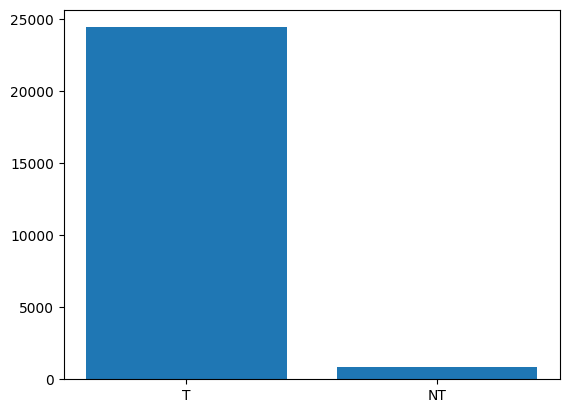

In [12]:
PATH_TO_DIR = '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/binary_data/'

freq = [(len(os.listdir(PATH_TO_DIR + dir)), dir) \
        for dir in os.listdir(PATH_TO_DIR) \
        if '.' not in dir]
print(freq)
plt.bar([f[1] for f in freq], [f[0] for f in freq])

## Splitting data into separate train and test sets for oversampling

In [16]:
import shutil

PATH = '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/skin_lesion_data/'

for dir in os.listdir(PATH):
    if '.' not in dir:
        files = os.listdir(PATH + dir)
        train_lst = files[:int(0.9*len(files))]
        tst_lst = files[int(0.9*len(files)):]

        print(dir, (len(train_lst), len(tst_lst)))

        if dir == 'SCC' or dir == 'VASC':
            for f in train_lst:
                shutil.copy(PATH + dir + '/' + f, '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/aug_binary_data/train/NT')
            for f in tst_lst:
                shutil.copy(PATH + dir + '/' + f, '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/aug_binary_data/test/NT')
        else:
            for f in train_lst:
                shutil.copy(PATH + dir + '/' + f, '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/aug_binary_data/train/T')
            for f in tst_lst:
                shutil.copy(PATH + dir + '/' + f, '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/aug_binary_data/test/T')

MEL (4069, 453)
SCC (565, 63)
VASC (227, 26)
AK (780, 87)
NV (11587, 1288)
BKL (2361, 263)
DF (215, 24)
BCC (2990, 333)


## Oversampling for minority class

In [24]:
import cv2

For oversampling we are using the following techniques:
- Rotation(0, 10, 350, 355 degrees)
- Vertical flipping
- Horizontal flipping
- Translation
- Adding Gaussian noise 

In [17]:
PATH = '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/aug_binary_data/train/NT/'
for im in os.listdir(PATH):
    img = cv2.imread(PATH + im)

    (rows, cols) = img.shape[:2] 

    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 5, 1) 
    res = cv2.warpAffine(img, M, (cols, rows), borderValue=(255,255,255)) 
    cv2.imwrite(PATH + im + '_1.jpg', res)

    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 10, 1) 
    res = cv2.warpAffine(img, M, (cols, rows), borderValue=(255,255,255)) 
    cv2.imwrite(PATH + im + '_2.jpg', res)

    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 350, 1) 
    res = cv2.warpAffine(img, M, (cols, rows), borderValue=(255,255,255)) 
    cv2.imwrite(PATH + im + '_3.jpg', res)

    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 355, 1) 
    res = cv2.warpAffine(img, M, (cols, rows), borderValue=(255,255,255)) 
    cv2.imwrite(PATH + im + '_4.jpg', res)

    res = cv2.flip(img, 0)
    cv2.imwrite(PATH + im + '_5.jpg', res)

    res = cv2.flip(img, 1)
    cv2.imwrite(PATH + im + '_6.jpg', res)

    quarter_height, quarter_width = rows / 4, cols / 4
    T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]]) 
    res = cv2.warpAffine(img, T, (cols, rows)) 
    cv2.imwrite(PATH + im + '_7.jpg', res)

    gauss_noise=np.zeros((rows,cols,3),dtype=np.uint8)
    cv2.randn(gauss_noise,128,20)
    gauss_noise=(gauss_noise*0.5).astype(np.uint8)
    res=cv2.add(img,gauss_noise)
    cv2.imwrite(PATH + im + '_8.jpg', res)

We increase the size of the dataset 8-fold.

[(2448, 'T'), (89, 'NT'), (22002, 'T'), (7128, 'NT')]


<BarContainer object of 4 artists>

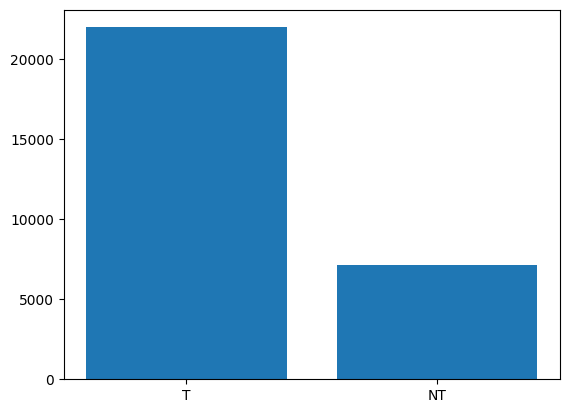

In [21]:
PATH_TO_DIR = '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/aug_binary_data/'

freq = [(len(os.listdir(PATH_TO_DIR + dir + '/' + subdir)), subdir) \
        for dir in os.listdir(PATH_TO_DIR) \
        for subdir in os.listdir(PATH_TO_DIR + dir + '/')
        if '.' not in subdir]
print(freq)
plt.bar([f[1] for f in freq], [f[0] for f in freq])

## Defining transformations and setting the DataLoaders

In [25]:
TRAIN_DIR = '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/aug_binary_data/train'
TEST_DIR = '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/aug_binary_data/test'

# transform the image size to 255 by 255 and then center crop
transform = transforms.Compose([
      transforms.Resize(255),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225])])

# load train/valid/test set using ImageFolder 
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)


# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

## Loading the pre-trained model

- We are using the pre-trained VGG-16 model here mainly because of the comparatively lesser complexity it has. It is very widely used as a feature extractor and using a more complex model in such an imbalance setting may lead to overfitting.
- Additionally, we keep the class-weighted strategy along with the oversampling here.

In [26]:
# Load pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze convolutional layers to keep the pretrained weights
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the classifier to match the number of classes in your dataset
num_classes = len(dataset.classes)
vgg16.classifier[-1] = nn.Linear(vgg16.classifier[-1].in_features, num_classes)

# Sample counts
t_samples = 22002
nt_samples = 7128

# # Calculate class weights
class_weights = [t_samples / nt_samples, nt_samples / t_samples]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Move to device (cuda or cpu)

# Define loss criterion and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
# specify optimizer (stochastic gradient descent) and learning rate
optimizer = optim.Adam(vgg16.parameters(), lr=1e-5)

/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Fine-tuning the model

In [28]:
# Train the model
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    # count = 0
    for inputs, labels in train_loader:
        # if count > 2:
        #   break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # count+=1
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 0.33030585669038326
Epoch 2/5, Loss: 0.18381670879202144
Epoch 3/5, Loss: 0.12129593867109321
Epoch 4/5, Loss: 0.07670654510132535
Epoch 5/5, Loss: 0.048088848538713126


In [ ]:
PATH = '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/models/'
if not os.path.exists(PATH + 'binary/'):
    os.mkdir(PATH + 'binary/')
    
torch.save(vgg16, PATH + 'binary/vgg16_finetuned_binary_min_oversampled_wt.PTH')

### Model evaluation

- All the tests have been done on a separated out test set. 
- The classification report highlights some of the main performance metrics. Here, `0 = 'NT'` class and `1 = 'T'` class.
- The recall of `T` class refers to the sensitivity and that of the `NT` class refers to the specificity.
- We have also reported the confusion matrix at the end.

In [29]:
# Testing
correct = 0
total = 0
y_predicted = []
y_label = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # predicted.append(torch.max(outputs.data, 1)[1])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_predicted.extend(predicted.cpu().numpy())
        y_label.extend(labels.cpu().numpy())

Test Accuracy: 93.73275522270399%

############ CLASSIFICATION REPORT ############
              precision    recall  f1-score   support

           0       0.32      0.72      0.45        89
           1       0.99      0.95      0.97      2448

    accuracy                           0.94      2537
   macro avg       0.66      0.83      0.71      2537
weighted avg       0.97      0.94      0.95      2537



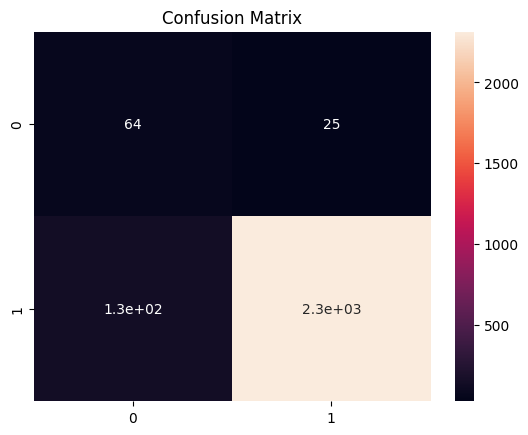

In [30]:
print(f"Test Accuracy: {100 * correct / total}%\n")

print('############ CLASSIFICATION REPORT ############')
print(classification_report(y_label,y_predicted))


confusion_matrix_df = pd.DataFrame(confusion_matrix(y_label, y_predicted))
ax = plt.axes()
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

ax.set_title('Confusion Matrix')
plt.show()

Thus, we find oversampling the data in this case did not lead to any significant improvement in the performance of the model.

We believe, other strategies to deal with class imbalance might be a good approach in this case, for instance generating synthetic data or in fact undersampling the majority class.